<a href="https://www.kaggle.com/shashank069/chest-xray-classification?scriptVersionId=90071281" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
import tensorflow as tf

# DATA PRE-PROCESSING

In [2]:
train=pd.read_csv('../input/data/Data_Entry_2017.csv')
img_paths={os.path.basename(x): x for x in glob(os.path.join('..', 'input','data','images*', '*', '*.png'))}
train['img_path']=train['Image Index'].map(img_paths.get)#mapping image ids to all image paths

In [3]:
train.isnull().sum()

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
img_path                            0
dtype: int64

In [4]:
#train.drop(columns=['Unnamed: 11'],inplace=True)#dropping null values
train.sample(5,random_state=42)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,img_path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,NaN,../input/data/images_010/images/00022260_003.png
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_006/images/00012048_007.png
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,NaN,../input/data/images_007/images/00014352_005.png
22863,00006040_001.png,No Finding,1,6040,18,F,AP,2500,2048,0.171,0.171,NaN,../input/data/images_003/images/00006040_001.png
43431,00011202_002.png,No Finding,2,11202,19,M,AP,2500,2048,0.168,0.168,NaN,../input/data/images_005/images/00011202_002.png


In [5]:
train=train[['Finding Labels','Patient ID','img_path']]

"Finding Labels" has multiple labels in the same column. To better extract all different labels of an image, we need to separate these.

In [6]:
#Finding unique all labels
labels=train['Finding Labels'].str.split('|',expand=True).stack().unique()
for l in labels:
    train[l]=train['Finding Labels'].map(lambda x:1 if l in x else 0)
train.drop(columns=["Finding Labels"],inplace=True)

In [7]:
train.sample(5,random_state=42)

,Patient ID,img_path,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
89645,22260,../input/data/images_010/images/00022260_003.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
47446,12048,../input/data/images_006/images/00012048_007.png,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0
57963,14352,../input/data/images_007/images/00014352_005.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
22863,6040,../input/data/images_003/images/00006040_001.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
43431,11202,../input/data/images_005/images/00011202_002.png,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


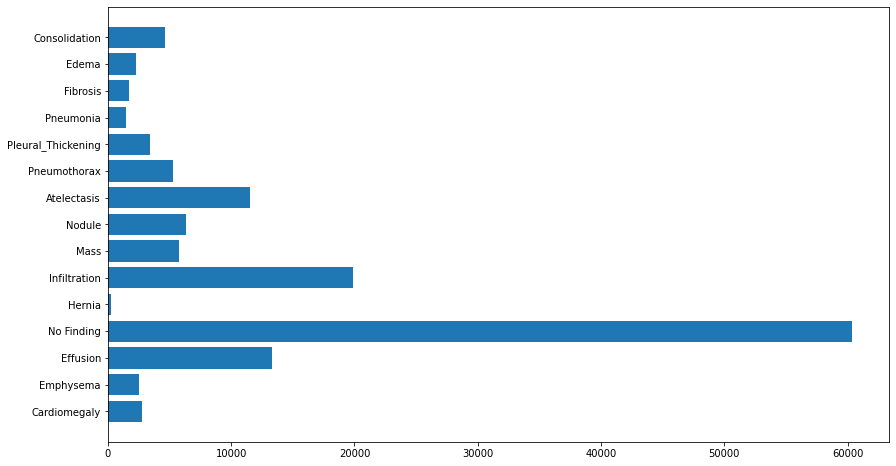

In [8]:
a=train.drop(columns=['Patient ID','img_path']).sum().values
b=train.drop(columns=['Patient ID','img_path']).sum().index
plt.subplots(figsize=(14,8))
plt.barh(b,a)
plt.show()

In [9]:
train.drop(columns=['Patient ID','img_path']).sum()/len(train)

Cardiomegaly          0.024759
Emphysema             0.022440
Effusion              0.118775
No Finding            0.538361
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
Nodule                0.056466
Atelectasis           0.103095
Pneumothorax          0.047289
Pleural_Thickening    0.030191
Pneumonia             0.012763
Fibrosis              0.015037
Edema                 0.020540
Consolidation         0.041625
dtype: float64

The dataset is highly imbalanced.Around 54% patients have no disease, and Infiltration, with highest disease prevalance, is also present in ony 18% cases. We'll account for this imbalance by modifying the loss function. Although, this can also be done using resampling techniques.

# Preparing training and validation sets

There are multiple images for a single patient, hence, while making the training and validation sets, we need to ensure that no patient is part of both datasets. Otherwise, we'll be comitting data leakage.

In [10]:
ids=set(train['Patient ID'].unique().flatten())
train_ids=set(np.random.choice(train['Patient ID'].unique(),int(len(train['Patient ID'].unique())*0.75),replace=False).flatten())
val_ids=set(ids)-set(train_ids)

In [11]:
val=train[train['Patient ID'].isin(val_ids)]
train=train[train['Patient ID'].isin(train_ids)]

We'll now use Keras library to make an image generator. This'll provide arrays of image pixel values which we can then use to train the model. The generator will be initialized such that the pixel values are standardized for the training sample. 

In [12]:
#Declaring image generator to standardize pixel values
img_gen=ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True)

In [13]:
def img_dataset(base,df_inp,path,targets):
    base_dir='../input/data/'
    df_gen = base.flow_from_dataframe(dataframe=df_inp, 
                                     directory='',
                                     x_col=path,
                                     y_col=targets,
                                     class_mode="raw",
                                     batch_size=16,
                                     target_size=(320,320))
    return df_gen

In [14]:
train_gen=img_dataset(img_gen,train,'img_path',train.columns[2:])
val_gen=img_dataset(img_gen,val,'img_path',val.columns[2:])

Found 83680 validated image filenames.
Found 28440 validated image filenames.


# Modifying Loss function

We'll create a custom weigted loss function depending on the frequency of each lablel. Doing so will make sure that the model is giving equal weightage to loss from all label categories.

In [15]:
positive_wts=np.array(train.drop(columns=['Patient ID','img_path']).sum(axis=0))/len(train)
negative_wts=1-positive_wts

In [16]:
def weighted_loss(true,pred):
    loss=0
    true=tf.cast(true, dtype='float32')
    for i in range(len(positive_wts)):
            loss += K.mean(-(positive_wts[i] *true[:,i] * K.log(pred[:,i] + 1e-7) 
                             + negative_wts[i]* (1 - true[:,i]) * K.log( 1 - pred[:,i] + 1e-7)))
    return loss

# Model using transfer learning

We'll now use pretrained densenet model to fit the training data. Besides the final two blocks and the layers we add to the pre-existing model, all layers will remain untrainable.

In [17]:
model = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet")
x = model.output
x = GlobalAveragePooling2D()(x)
preds = Dense(len(labels), activation="sigmoid")(x)
model = Model(inputs=model.input, outputs=preds)
model.compile(optimizer='adam', loss=weighted_loss)

2022-03-14 12:07:46.599647: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 12:07:46.692537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 12:07:46.693215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-14 12:07:46.694324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

51888128/51877672 [==============================] - 1s 0us/step


In [18]:
layers_train=['conv5_block30']
for layer in model.layers:
    if 'conv5_block31' in layer.name or 'conv5_block32' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False
model.layers[-2].trainable=True
model.layers[-1].trainable=True

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-03-14 12:07:54.339450: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/3


2022-03-14 12:08:11.482763: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


100/100 [==============================] - 93s 691ms/step - loss: 0.9583 - val_loss: 0.8567
Epoch 2/3
100/100 [==============================] - 74s 743ms/step - loss: 0.6362 - val_loss: 0.8503
Epoch 3/3
100/100 [==============================] - 73s 728ms/step - loss: 0.6690 - val_loss: 0.6453


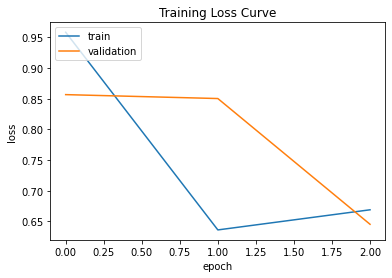

In [19]:
history = model.fit_generator(train_gen, 
                              validation_data=val_gen,
                              steps_per_epoch=100, 
                              validation_steps=25, 
                              epochs = 3)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.title("Training Loss Curve")
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Improvements
The model can improve on various fronts.
1. Firstly, we can use data augmentation (rotations, magnification,intensity etc) to train the model on more comprehensive data
2. We can also experiment by increasing or decreasing the number of trainable layers 